## Краткое описание

Fine-tuning модели VggFace для классификации лиц.

**Версия Python:** Python 3.6.6 (На основе ноутбука: [czy111/python 3.6.6](https://www.kaggle.com/code/czy111/python-3-6-6?scriptVersionId=166908451))

## Preparation

In [1]:
# Версия Python
!python --version > output/python_version.txt
!cat output/python_version.txt

Python 3.6.6 :: Anaconda, Inc.


In [5]:
from IPython.display import clear_output

!pip install livelossplot
!pip install gdown
!pip install git+https://github.com/rcmalli/keras-vggface.git

!pip freeze > output/pip_freeze.txt

clear_output()
print('Done!')

Done!


In [6]:
from tensorflow import config as tf_config
from tensorflow import __version__ as __tf_version__
from tensorflow import device as tf_device

physical_devices = tf_config.list_physical_devices('GPU')
print("GPUs Available: ", physical_devices)

for device in physical_devices:
    tf_config.experimental.set_memory_growth(device, True)

use_keras = True

if use_keras:
    import keras    
    from keras import backend as K
    from keras.preprocessing.image import ImageDataGenerator
    from keras.preprocessing import image
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau    
else:
    import tensorflow.keras as keras
    from tensorflow.keras import backend as K
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('keras backend: ', K.backend())
print("keras version: ", keras.__version__)
    
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

print("TF version: ", __tf_version__)

from livelossplot.tf_keras import PlotLossesCallback

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
keras backend:  tensorflow
keras version:  2.3.1
TF version:  2.1.0


Using TensorFlow backend.


In [7]:
import os
from pathlib import Path, PurePath
import shutil
import subprocess

import numpy as np
import pandas as pd
import math

from PIL import Image, ImageFilter, ImageEnhance

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split

import gdown
import time
import os

## Load data

In [8]:
csv_sm_sbm_path = "/kaggle/input/skillbox-computer-vision-project/sample_submission.csv"
csv_train_path = "/kaggle/input/skillbox-computer-vision-project/train.csv"

data_zip_url = "https://drive.google.com/file/d/1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16/view?usp=sharing"
data_zip_path = "data.zip"
data_folder_path = "./data"

# test_zip_url = "https://drive.google.com/file/d/12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K/view?usp=sharing"
# test_zip_path = "test_kaggle.zip"
# test_folder_path = "./test_kaggle"

train_folder_path = "./train_data"
test_folder_path = "./test_data"

In [21]:
!ls

data	  output    test_data	vggface_model_ft_checks
data.zip  state.db  train_data	vggface_model_ft_trial


In [11]:
# Скачивание данных
if not os.path.exists(data_zip_path):
    gdown.download(data_zip_url, data_zip_path, fuzzy=True)

In [12]:
# Распаовка данных
if not os.path.exists(data_folder_path):
    print(f'Unpacking {data_zip_path}...')
    shutil.unpack_archive(data_zip_path, '.', 'zip')
    shutil.move('./train', data_folder_path)

print('Done!')

Done!


In [13]:
!ls /kaggle/input

skillbox-computer-vision-project  vggface_model_ft_check


In [19]:
!ls

data	  output    test_data	vggface_model_ft_checks
data.zip  state.db  train_data	vggface_model_ft_trial


In [15]:
sm_sbm_df = pd.read_csv(csv_sm_sbm_path)
train_df = pd.read_csv(csv_train_path, index_col='Unnamed: 0')

In [16]:
def reformat_path(path):
    return str(PurePath(*PurePath(path).parts[1:]))

In [17]:
data_df = pd.read_csv(csv_train_path, index_col='Unnamed: 0')
data_df['image_path'] = data_df['image_path'].apply(reformat_path)
data_df['image_path']

0              anger/0.jpg
1              anger/1.jpg
2             anger/10.jpg
3            anger/100.jpg
4           anger/1000.jpg
               ...        
50041    uncertain/995.jpg
50042    uncertain/996.jpg
50043    uncertain/997.jpg
50044    uncertain/998.jpg
50045    uncertain/999.jpg
Name: image_path, Length: 50046, dtype: object

In [18]:
def stratified_split_df(dataframe, validation_split=0.2, seed=None):
    random_seed = np.random.RandomState(seed=seed)
    indices = []

    for category in dataframe['emotion'].unique():
        category_df = dataframe[dataframe['emotion'] == category]
        category_df_len = int(category_df.shape[0] * validation_split)
        category_indices = random_seed.choice(category_df.index, size=category_df_len, replace=False)
        indices.extend(list(category_indices))

    train_part = dataframe.drop(indices, axis=0)
    val_part = dataframe.loc[indices,:]

    return train_part, val_part

In [19]:
train_df, test_df = stratified_split_df(
    data_df,
    validation_split=0.2,
    seed=42
)

print(f'train_df shape {train_df.shape}')
print(f'test_df shape {test_df.shape}')

train_df shape (40039, 2)
test_df shape (10007, 2)


In [20]:
!ls data

anger  contempt  disgust  fear	happy  neutral	sad  surprise  uncertain


In [21]:
# Сортировка изображений (train)

soource_folder = Path(data_folder_path)
target_folder = Path(train_folder_path)

for index, d in train_df.iterrows():
    soource = soource_folder / d['image_path']
    target = target_folder / d['image_path']

    Path(*target.parts[:-1]).mkdir(parents=True, exist_ok=True)

    try:
        shutil.copy(soource, target)
    except FileNotFoundError:
        pass

In [22]:
# Сортировка изображений (test)

soource_folder = Path(data_folder_path)
target_folder = Path(test_folder_path)

for index, d in test_df.iterrows():
    soource = soource_folder / d['image_path']
    target = target_folder / d['image_path']

    Path(*target.parts[:-1]).mkdir(parents=True, exist_ok=True)

    try:
        shutil.copy(soource, target)
    except FileNotFoundError:
        pass

In [23]:
# Обновление путей
train_df['image_path'] = train_df['image_path'].apply(lambda path: Path(train_folder_path) / path)
test_df['image_path'] = test_df['image_path'].apply(lambda path: Path(test_folder_path) / path)

In [24]:
data_df.loc[train_df.index, 'image_path'] = train_df['image_path']
data_df.loc[test_df.index, 'image_path'] = test_df['image_path']

In [25]:
data_df.head()

,image_path,emotion
0,train_data/anger/0.jpg,anger
1,train_data/anger/1.jpg,anger
2,train_data/anger/10.jpg,anger
3,train_data/anger/100.jpg,anger
4,train_data/anger/1000.jpg,anger


In [26]:
train_df.head()

,image_path,emotion
0,train_data/anger/0.jpg,anger
1,train_data/anger/1.jpg,anger
2,train_data/anger/10.jpg,anger
3,train_data/anger/100.jpg,anger
4,train_data/anger/1000.jpg,anger


In [27]:
test_df.head()

,image_path,emotion
3909,test_data/anger/4516.jpg,anger
2462,test_data/anger/3213.jpg,anger
2879,test_data/anger/359.jpg,anger
3761,test_data/anger/4383.jpg,anger
3745,test_data/anger/4369.jpg,anger


## Data Preparation

In [28]:
data_folder_path

'./data'

In [29]:
train_df.head()

,image_path,emotion
0,train_data/anger/0.jpg,anger
1,train_data/anger/1.jpg,anger
2,train_data/anger/10.jpg,anger
3,train_data/anger/100.jpg,anger
4,train_data/anger/1000.jpg,anger


In [20]:
!ls

data	  output    test_data	vggface_model_ft_checks
data.zip  state.db  train_data	vggface_model_ft_trial


In [31]:
def build_generators(train=train_df, val=test_df, batch_size=128, image_size=16, preprocessing_function_train=None, preprocessing_function_val=None):
    
    train['image_path'] = train['image_path'].dropna().apply(str)
    val['image_path'] = val['image_path'].dropna().apply(str)
    
    train_image_generator = ImageDataGenerator(rotation_range=15,
                                               width_shift_range=.15,
                                               height_shift_range=.15,
                                               horizontal_flip=True,
                                               fill_mode='nearest',
                                               brightness_range=(0.6, 1.4),
                                               shear_range=0.2,
                                               preprocessing_function=preprocessing_function_train)

    train_generator = train_image_generator.flow_from_dataframe(dataframe=train,
                                                                x_col='image_path',
                                                                y_col='emotion',
                                                                target_size=(image_size, image_size),
                                                                batch_size=batch_size,
                                                                class_mode='sparse',
                                                                directory='.',
                                                                shuffle=True,
                                                                interpolation='nearest',
                                                                validate_filenames=True)

    val_image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function_val)

    val_generator = val_image_generator.flow_from_dataframe(dataframe=val,
                                                            directory='.',
                                                            x_col='image_path',
                                                            y_col='emotion',
                                                            target_size=(image_size, image_size),
                                                            batch_size=batch_size,
                                                            class_mode='sparse',
                                                            shuffle=False,
                                                            interpolation='nearest',
                                                            validate_filenames=True)

    return train_generator, val_generator

In [32]:
def add_noise(noise_typ, img):

    image = img / 255.
    if noise_typ == "gauss":
        row, col, ch = image.shape
        mean = 0
        var = 0.002
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        out = gauss + image
        out =  np.clip(out, 0, 1)
    elif noise_typ == "s&p":
        row, col, ch = image.shape
        s_vs_p = 0.5
        amount = 0.02
        out = np.copy(image)

        # "Salt"
        num_salt = np.ceil(amount * row * col * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
        out[tuple(coords)] = np.random.uniform(0.6, 1.0)

        # "Pepper"
        num_pepper = np.ceil(amount* row * col * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
        out[tuple(coords)] = np.random.uniform(0, 0.4)
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        out = np.clip(noisy, 0, 1)
    return (out * 255).astype(np.uint8)


def apply_filter(filter_type, img):

    image = Image.fromarray(img)
    if filter_type == 'blur':
        out = image.filter(filter=ImageFilter.BLUR)
    elif filter_type == 'color':
        enhancer = ImageEnhance.Color(image)
        out = enhancer.enhance(np.random.uniform(0.4, 1.3))
    elif filter_type == 'gblur':
        out = image.filter(ImageFilter.GaussianBlur(1))
    return np.array(out)


def random_transformation(image):

    transformations = [lambda x: add_noise('gauss', x),
                       lambda x: add_noise('s&p', x),
                       lambda x: add_noise('poisson', x),
                       lambda x: apply_filter('blur', x),
                       lambda x: apply_filter('gblur', x),
                       lambda x: x] # no filter
    p = [0.12, 0.12, 0.12, 0.12, 0.12, 0.40]
    trans_fn = np.random.choice(transformations, p=p)

    return apply_filter('color', trans_fn(image.astype(np.uint8))).astype(image.dtype)

## Callbacks

In [33]:
def build_callbacks(save_path: str):

    path = Path(save_path)
    path.mkdir(exist_ok=True)
    cpt_filename = "checkpoint_best.hdf5"
    cpt_path =str(path / cpt_filename)

    model_checkpoint = ModelCheckpoint(cpt_path,
                                       monitor='val_sparse_categorical_accuracy',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max')

    model_lr_reducer = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                         patience=2,
                                         factor=0.2,
                                         mode='max')

    model_stopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0, patience=6, mode='auto')

    return model_checkpoint, model_lr_reducer, model_stopper

## Modeling

In [34]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

94699520/94694792 [==============================] - 0s 0us/step


In [35]:
# vggface_model.summary()

In [36]:
vggface_model.trainable = False
vggface_model_ft = keras.models.Sequential([
    vggface_model,
    keras.layers.Flatten(input_shape=(None, None, 2048)),
    keras.layers.Dense(9, activation='softmax')
])

In [37]:
vggface_model_ft.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 18441     
Total params: 23,579,593
Trainable params: 18,441
Non-trainable params: 23,561,152
_________________________________________________________________


In [38]:
def preprocess_vgg_train(image_):
    
    image_ = random_transformation(image_)
    preprocessed_image = utils.preprocess_input(image_, version=2)

    return preprocessed_image

In [39]:
def preprocess_vgg_val(image_):
    preprocessed_image = utils.preprocess_input(image_, version=2)
    return preprocessed_image

In [40]:
train_gen, val_gen = build_generators(image_size=224,
                                      batch_size=128,
                                      preprocessing_function_train=preprocess_vgg_train,
                                      preprocessing_function_val=preprocess_vgg_val)

Found 40039 validated image filenames belonging to 9 classes.
Found 10007 validated image filenames belonging to 9 classes.


In [41]:
vggface_model_ft.load_weights("/kaggle/input/vggface_model_ft_check/keras/ep40/1/vggface_model_ft_check_ep60.hdf5")

In [42]:
vggface_model_ft.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [43]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="vggface_model_ft_checks")

Запуск следующей ячейки (обучения) произведен 3 раза (60 эпох).

Чекпоинты модели поссле каждых 20-и эпох сохранялись здесь: [ilapro53/vggface_model_ft_check](https://www.kaggle.com/models/ilapro53/vggface_model_ft_check/)

Последняя модель: [ilapro53/vggface_model_ft_check/keras/ep60](https://www.kaggle.com/models/ilapro53/vggface_model_ft_check/keras/ep60)

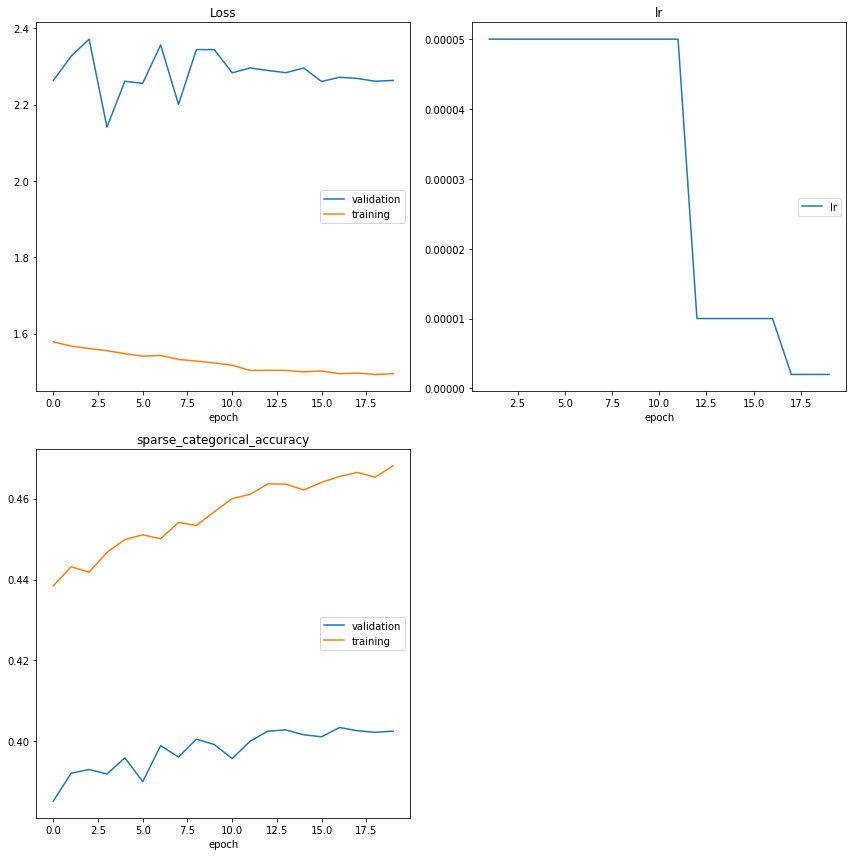

Loss
	validation       	 (min:    2.141, max:    2.371, cur:    2.263)
	training         	 (min:    1.493, max:    1.578, cur:    1.495)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
sparse_categorical_accuracy
	validation       	 (min:    0.385, max:    0.403, cur:    0.403)
	training         	 (min:    0.438, max:    0.468, cur:    0.468)

Epoch 00020: val_sparse_categorical_accuracy did not improve from 0.40342
CPU times: user 5h 39min 34s, sys: 13min 5s, total: 5h 52min 40s
Wall time: 5h 29min 3s


In [45]:
%%time

# 3rd run
vggface_model_ft.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper],
)

In [51]:
vggface_model_ft.evaluate(val_gen)

79/79 [==============================] - 72s 913ms/step


[2.263110876083374, 0.40251824259757996]

## Завершение

In [5]:
!mkdir -p output/model
!cp /kaggle/working/vggface_model_ft_checks/checkpoint_best.hdf5 /kaggle/working/output/model/vggface_model_ft_check_.hdf5

In [11]:
!ls /kaggle/input/vggface_model_ft_check/keras/

ep20  ep40  ep60


In [ ]:
# !md5sum /kaggle/input/vggface_model_ft_check/keras/ep60/1/vggface_model_ft_check_ep60.hdf5 
# !md5sum /kaggle/working/vggface_model_ft_checks/checkpoint_best.hdf5
# !md5sum /kaggle/working/output/model/vggface_model_ft_check_.hdf5